In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import auc, roc_curve, roc_auc_score,  classification_report, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, plot_confusion_matrix
from helper_functions import *
from pipeline import *

In [2]:
X = pipeline('../data/stratified_train.csv', drop_cat=False)
y = X.pop('Target')
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

/Users/chelseazaloumis/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


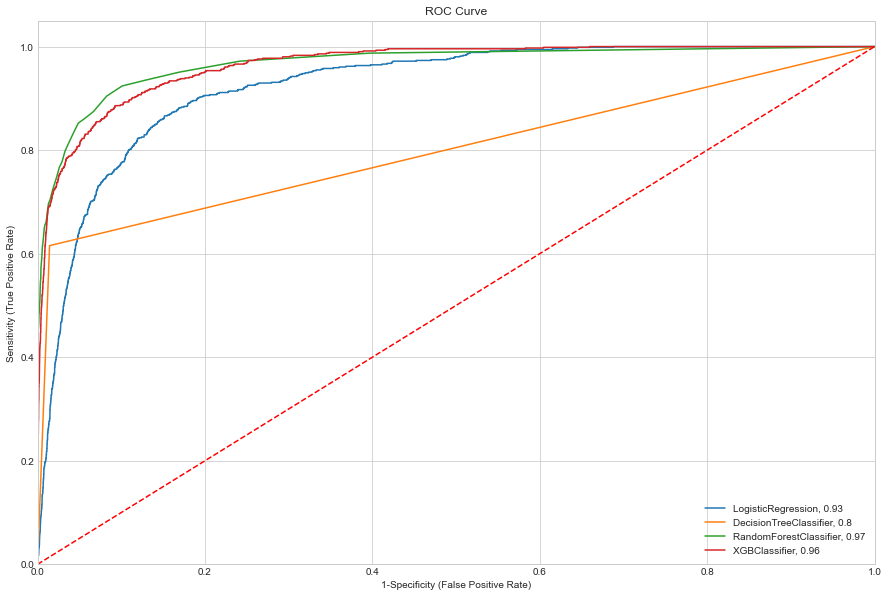

In [3]:
classification_models = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(class_weight='balanced'), XGBClassifier()]
model_comparison(classification_models, X_train, y_train, X_test, y_test)
#plt.savefig('../images/initial_comparison.png');

Accuracy is not a valid evaluation metric because of the class imbalance.

Which is worse: **FP** or **FN**?

*Reason shows a **FN** (like ignoring a fire alarm) is MUCH WORSE.*

$$Recall = \frac{TP}{TP + FN}$$

Therefore **Recall** is the best metric to evaluate the models by. Therefore out-of-box Random Forest outperforms XGB.

In [9]:
rf = RandomForestClassifier(class_weight='balanced')
rf_recall_scores = cross_val_score(rf, X_train, y_train,
                           scoring='recall', cv=5, n_jobs=-1)
print('RF OOB Recall', np.mean(rf_recall_scores))

rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)
print('Out of box RF:')
print(classification_report(y_test, rf_y_pred))

RF OOB Recall 0.3686619718309859
Out of box RF:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     22707
           1       0.97      0.44      0.60       710

    accuracy                           0.98     23417
   macro avg       0.98      0.72      0.80     23417
weighted avg       0.98      0.98      0.98     23417



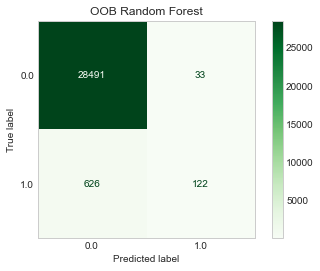

In [21]:
plot_confusion_matrix(rf, X_test, y_test, cmap=plt.cm.Greens)
plt.title('OOB Random Forest')
plt.grid(False);

In [14]:
recall_score(y_test, rf_y_pred)

0.4394366197183099

In [10]:
xgb = XGBClassifier()
xgb_recall_scores = cross_val_score(xgb, X_train, y_train,
                           scoring='recall', cv=5, n_jobs=-1)
print('XGB OOB Recall', np.mean(xgb_recall_scores))

xgb.fit(X_train, y_train)
xgb_y_pred = xgb.predict(X_test)
print('Out of box XGB:')
print(classification_report(y_test, xgb_y_pred))

XGB OOB Recall 0.3799295774647887
Out of box XGB:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     22707
           1       0.83      0.41      0.55       710

    accuracy                           0.98     23417
   macro avg       0.90      0.70      0.77     23417
weighted avg       0.98      0.98      0.98     23417



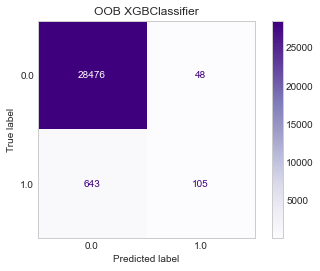

In [20]:
plot_confusion_matrix(xgb, X_test, y_test, cmap=plt.cm.Purples)
plt.title('OOB XGBClassifier')
plt.grid(False);

In [16]:
recall_score(y_test, xgb_y_pred)

0.4070422535211268

*Both RF and XGB are overfitting to training data. XGB outperforms RF OOB very slightly with cross validation.*

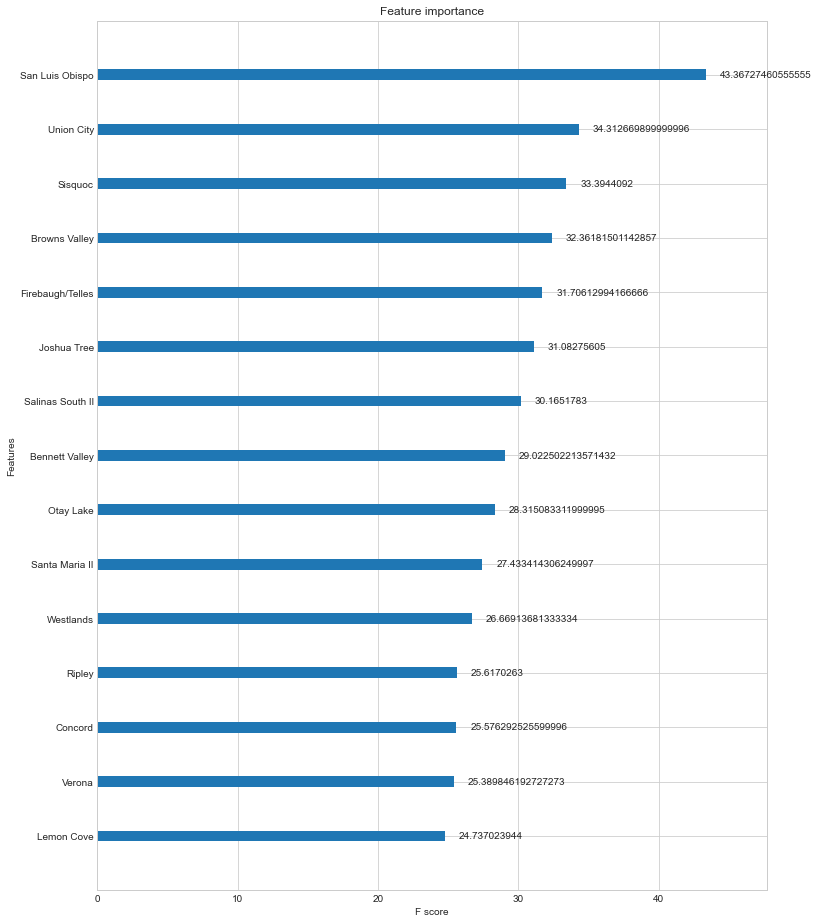

In [26]:
fig, ax = plt.subplots(figsize=(12,16))
plot_importance(xgb, ax=ax, max_num_features=15, importance_type='gain');

XGB's top 15 features to split on for maximum average gain. To better understand the tabular dataset, creating another data pipeline that removes the `Stn Id` column before one-hot encoding all stations.

In [2]:
X = pipeline('../data/stratified_train.csv')
y = X.pop('Target')
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [3]:
xgb = XGBClassifier()
xgb_recall_scores = cross_val_score(xgb, X_train, y_train,
                           scoring='recall', cv=5, n_jobs=-1)
print('XGB OOB Recall', np.mean(xgb_recall_scores))

xgb.fit(X_train, y_train)
xgb_y_pred = xgb.predict(X_test)
print('Out of box XGB:')
print(classification_report(y_test, xgb_y_pred))

XGB OOB Recall 0.13450704225352114
Out of box XGB:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     22707
           1       0.78      0.17      0.29       710

    accuracy                           0.97     23417
   macro avg       0.87      0.59      0.64     23417
weighted avg       0.97      0.97      0.97     23417



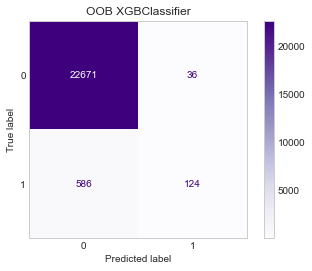

In [4]:
plot_confusion_matrix(xgb, X_test, y_test, cmap=plt.cm.Purples)
plt.title('OOB XGBClassifier')
plt.grid(False);

In [5]:
recall_score(y_test, xgb_y_pred)

0.17464788732394365

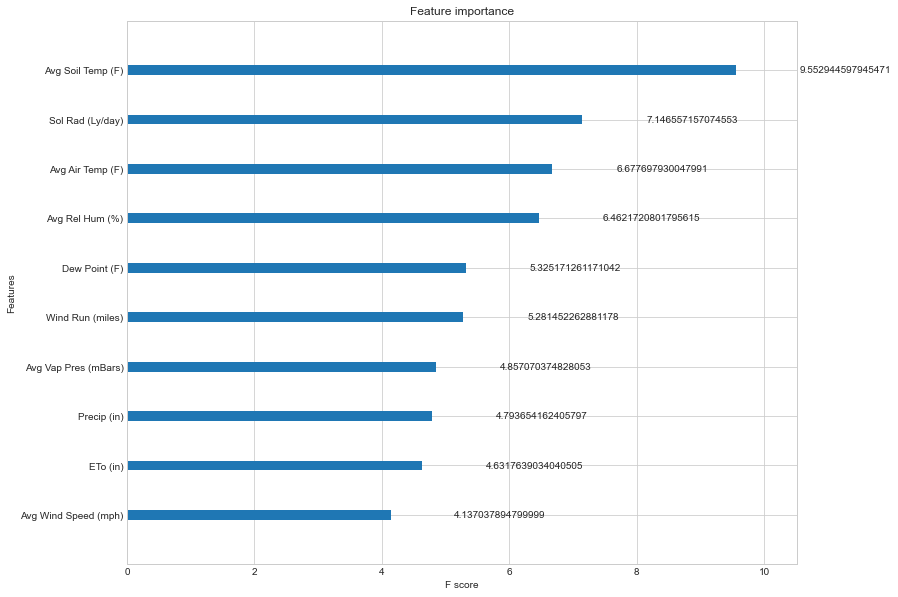

In [10]:
fig, ax = plt.subplots(figsize=(12,10))
plot_importance(xgb, ax=ax, importance_type='gain');

*XGB performs MUCH MUCH MUCH worse with only numerical features.*

In [16]:
exp_X_train = pd.DataFrame(X_train['Avg Soil Temp (F)']).copy()
exp_X_test = pd.DataFrame(X_test['Avg Soil Temp (F)']).copy()
clf = LogisticRegression()
clf.fit(exp_X_train, y_train)
clf_y_pred = clf.predict(exp_X_test)
recall_score(y_test, clf_y_pred)

0.0

In [17]:
clf.coef_

array([[0.8670423]])